# Detecção e Classificação de Conexões Maliciosas
### Joás de Brito Ferreira Filho
Projeto Final requerido na disciplina de Introdução à Ciência de Dados, ministrada na UFPB pelo professor Yuri Malheiros (https://github.com/yurimalheiros)

Dataset obtido no endereço: https://www.kaggle.com/mrwellsdavid/unsw-nb15

### Requisitos do Sistema

In [47]:
# tools we will need
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputClassifier
import pickle
from google.colab import files

In [3]:
# get the dataset
df = pd.read_csv("https://raw.githubusercontent.com/J0AZZ/data-science_studies/master/IACD-UFPB/UNSW_NB15/UNSW_NB15_training-set.csv")

### Análise Exploratória dos Dados

Esta seção introduz o problema por meio da análise exploratória dos dados e de visualizações relevantes.

O dataset foi gerado a partir da ferramenta `IXIA PerfectStorm`, na Cyber Range Lab of the Australian Centre for Cyber Security (`ACCS`) para discriminar conexões normais de conexões anormais. Dentre as conexões denominadas anormais, deve-se distingui-las entre os ataques cibernéticos contemporâneos; este dataset abrange nove diferentes tipos de ataque, além de apresentar outros atributos interessantes, a serem explorados nesta seção.

In [4]:
# a first look at the data
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


Devemos ter uma ideia geral da tipagem de cada coluna; além do mais, o comando `pd.DataFrame.info()` nos dá a contagem dos valores nulos, uma informação valiosa.

In [5]:
# dataset's general structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

Verificaremos agora algumas estatísticas importantes, a saber, medidas de dispersão e centralidade. A partir destas informações podemos estudar o problema através de **visualizações**.

As colunas exibidas referem-se, respectivamente, à duração da conexão, ao número de bytes transmitidos do servidor e ao número de bytes transmitidos do cliente.

In [6]:
# get summary statistics
summary = df.describe()
summary[['dur', 'sbytes', 'dbytes']]

,dur,sbytes,dbytes
count,82332.000000,8.233200e+04,8.233200e+04
mean,1.006756,7.993908e+03,1.323379e+04
std,4.710444,1.716423e+05,1.514715e+05
min,0.000000,2.400000e+01,0.000000e+00
25%,0.000008,1.140000e+02,0.000000e+00
50%,0.014138,5.340000e+02,1.780000e+02
75%,0.719360,1.280000e+03,9.560000e+02
max,59.999989,1.435577e+07,1.465753e+07


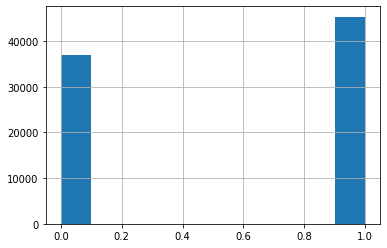

In [7]:
# verify if the two main categories are imbalanced
df['label'].value_counts()
df['label'].hist()

A exploração de dados categóricos envolve um pouco mais de refinamento.

In [8]:
# get numerical columns
numerical_cols = summary.keys()

# get categorical data
categorical_df = df.drop(numerical_cols, axis=1)
categorical_df.head()

,proto,service,state,attack_cat
0,udp,-,INT,Normal
1,udp,-,INT,Normal
2,udp,-,INT,Normal
3,udp,-,INT,Normal
4,udp,-,INT,Normal


In [9]:
categorical_df.describe()

,proto,service,state,attack_cat
count,82332,82332,82332,82332
unique,131,13,7,10
top,tcp,-,FIN,Normal
freq,43095,47153,39339,37000


Abaixo, as distribuições de frequência dos protocolos, serviços e tipos de ataque observados no dataset.

tcp     43095
udp     29418
unas     3515
arp       987
ospf      676
        ...  
gmtp       32
visa       32
micp       32
ib         31
igmp       30
Name: proto, Length: 131, dtype: int64


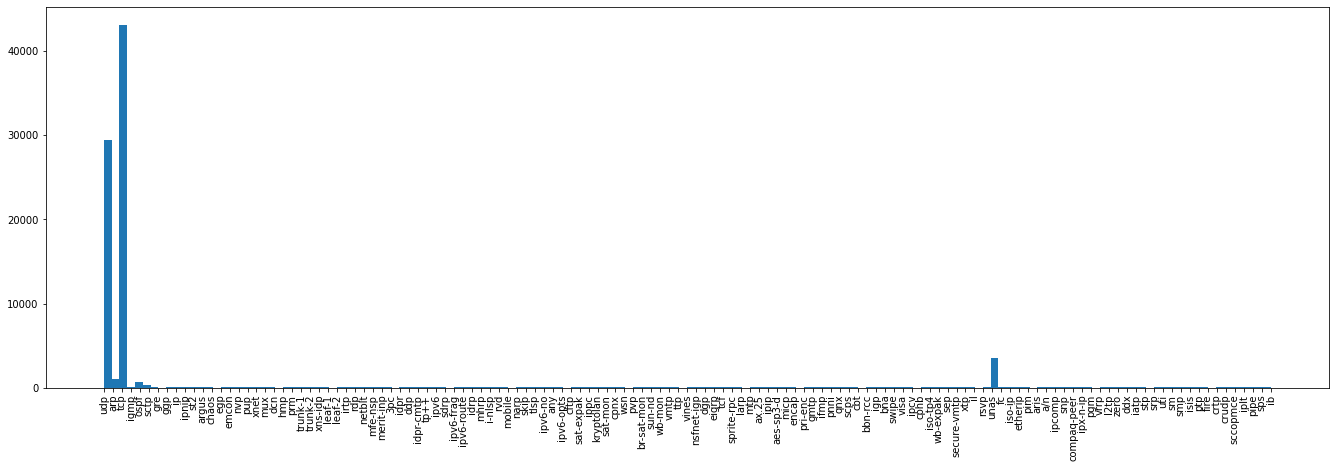

In [10]:
print(df['proto'].value_counts())
categorical_df['proto'].hist(xrot=90, xlabelsize=10, figsize=(23, 7), bins=150, grid=False)

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64


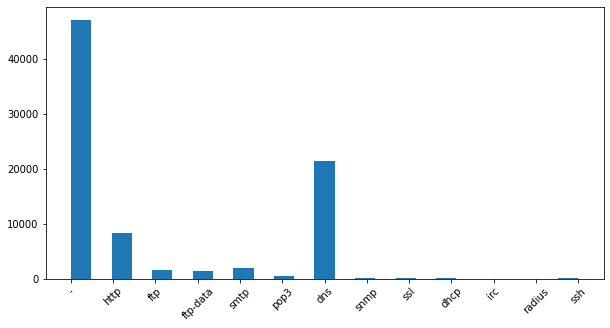

In [11]:
print(df['service'].value_counts())
categorical_df['service'].hist(xrot=45, bins=25, figsize=(10,5), grid=False)

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64


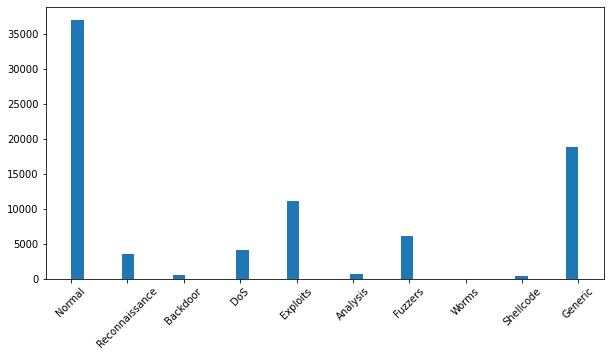

In [12]:
print(df['attack_cat'].value_counts())
categorical_df['attack_cat'].hist(xrot=45, grid=False, figsize=(10, 5), bins=40)

Podemos relacionar os protocolos/serviços aos ataques, visualizando a frequência de ocorrência em cada uma das observações.

In [13]:
attacks = df[df['label']==1]

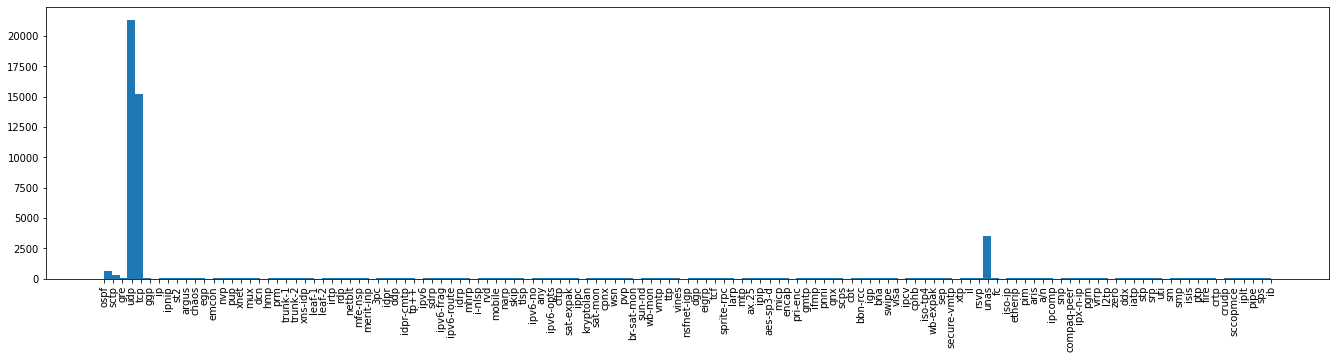

In [14]:
# protocols
attacks['proto'].hist(figsize=(23,5), xrot=90, bins=150, grid=False)

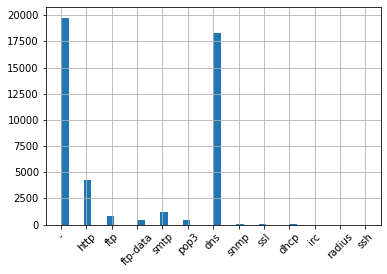

In [15]:
# services
attacks['service'].hist(bins=40, xrot=45)

### Pré-processamento dos Dados

Para gerar um modelo que explique bem o problema, é preciso alimentar este modelo com um dataset limpo, isto é: 
- sem dados faltantes;
- sem aberrações (dados de outro tipo, incoerentes, etc);
- cujas colunas sejam relevantes para a resolução do problema.



Para o primeiro passo na limpeza dos dados, verificaremos valores faltantes em todas as colunas do dataset.

In [16]:
total = 0
for i in range(45):
  total += df.iloc[:, i].isnull().sum()
print("Total null values: ", total)

Total null values:  0


Utilizaremos, a princípio, apenas os atributos mais relevantes. As seguintes colunas foram selecionadas por se relacionarem intimamente com a natureza da conexão, segundo a literatura:
`proto`, `service`, `dur`, `sbytes` e `dbytes`;

De modo que refinaremos nossa seleção a partir das medidas de correlação com a coluna `label`, como segue:

In [17]:
corr = df.corr()
relevant = corr['label'][abs(corr['label']) > .25]
relevant#.keys()

id                 -0.387489
rate                0.328629
sttl                0.504159
dload              -0.280534
swin               -0.414504
stcpb              -0.281428
dtcpb              -0.282860
dwin               -0.369257
ct_srv_src          0.290195
ct_state_ttl        0.318517
ct_dst_ltm          0.257995
ct_src_dport_ltm    0.341513
ct_dst_sport_ltm    0.393668
ct_dst_src_ltm      0.279989
ct_src_ltm          0.276494
ct_srv_dst          0.292931
label               1.000000
Name: label, dtype: float64

In [18]:
attributes = list(relevant.keys())[1:-1] # do not include ID nor label
for c in ['proto', 'service', 'dur', 'sbytes', 'dbytes']:
  attributes.append(c)

# take our new dataset by splitting up attributes and targets
raw_X = df[attributes]
raw_y_bin = df['label']
raw_y_mul = df['attack_cat']

Desta forma, podemos começar o tratamento dos dados categóricos.

In [19]:
# one-hot-encoding: categorical to numerical data
cat2num = pd.get_dummies(raw_X[['proto', 'service']])

Prosseguindo com a normalização dos dados numéricos.

In [20]:
# normalizing: scale all the values to lie between 0 and 1
normalized = pd.DataFrame(MinMaxScaler().fit_transform(raw_X.drop(['proto', 'service'], axis=1)))

Finalmente, podemos utilizar os dados em um modelo. 

In [21]:
X = pd.concat([cat2num, normalized], axis=1)
y_mul = pd.get_dummies(df['attack_cat'])

In [ ]:
X.shape

### Construção e Avaliação do Modelo

Abordaremos este problema como uma classificação multiclasse (normal/`attack_cat`...). 

Utilizaremos o modelo Extreme Gradiente Boosting (XGBoost), por sua comprovada eficiência e usabilidade.

Antes de alimentar o modelo, dividiremos o dataset em dois grupos, para que o modelo possa ser avaliado com exemplos que não foram usados no seu treinamento.

In [22]:
# training/validation
X_train, X_test, y_train, y_test = train_test_split(X, y_mul)

Os parâmetros utilizados abaixo são, em teoria, indispensáveis na construção do classificador multiclasse; ainda assim, o a acurácia do modelo não mudou significativamente, como se pode verificar no que segue.

In [31]:
# basic parameters to build the classifier
params = {'objective': "multi:softmax", 'num_class': 10}
xgbooster = XGBClassifier(**params)

In [32]:
# sklearn provides multioutput, a tool that allows us to train a model for each class
model = sk.multioutput.MultiOutputClassifier(xgbooster).fit(X_train, y_train) # run once, it might take a while (18min on colab GPU)

In [37]:
preds = model.predict(X_test)

In [45]:
# score without params: 78.10 %
# score with    params: 78.64 %

# built-in score method
print("Score: ", model.score(X_test, y_test)*100, " %")

Score:  78.64256911043094  %


In [44]:
# final classification report
print(sklearn.metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.09      0.16       158
           1       0.00      0.00      0.00       138
           2       0.44      0.06      0.11      1011
           3       0.83      0.54      0.65      2778
           4       0.86      0.46      0.60      1550
           5       1.00      0.96      0.98      4669
           6       0.95      0.94      0.95      9335
           7       0.95      0.77      0.85       845
           8       0.69      0.12      0.21        88
           9       1.00      0.36      0.53        11

   micro avg       0.94      0.79      0.86     20583
   macro avg       0.77      0.43      0.51     20583
weighted avg       0.91      0.79      0.83     20583
 samples avg       0.79      0.79      0.79     20583



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# save the model
dumped = pickle.dump(model, open('xgbooster_cyberattack-detector.pkl', 'wb'))
files.download('xgbooster_cyberattack-detector.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conclusão

Um problema de natureza determinística, dados limpos e de manuseio simplificado, bem como um algoritmo eficaz como o XGBoost levaram a um resultado satisfatório frente a dados que o modelo nunca viu. 

Melhorias poderiam apontar na direção da extração e modelagem de atributos, bem como uma parametrização mais personalizada do classificador. A utilidade do modelo (diga-se, a relevância do problema) é indiscutível no mundo contemporâneo, com a segurança da informação sustentando de sistemas bancários até a privacidade de um cidadão. 

As implicações de um ataque que não foi detectado podem variar do roubo (de informações ou bens materiais) à ameaça da integridade física de alguém. A prevenção e detecção efetiva de ataques cibernéticos via rede constituem um aparato indispensável na manutenção da ordem dentro da sociedade moderna.